In [72]:
import dgl
import numpy as np
import pandas as pd
import networkx as nx
import random
import json
import itertools

from helper_functions import build_map_1

import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv
import matplotlib.pyplot as plt
#from sklearn.metrics import mean_absolute_percentage_error

In [73]:
all_data = pd.read_csv("./state_wise_daily (1).csv")

In [74]:
# preprocess data, take confirmed alone and convert to datetime
cases_data = all_data[all_data['Status'] == 'Confirmed']
cases_data['Date'] = pd.to_datetime(cases_data['Date'])

c:\users\siddh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [75]:
states_ = open('../data/state_code_mapping.txt', 'r').read()
name_map_dict = dict([[s.rsplit(" ", 1)[0], s.rsplit(" ", 1)[1]] for s in states_.split('\n')])
del name_map_dict['Andaman and Nicobar Islands'], name_map_dict['Lakshadweep'], name_map_dict['Daman and Diu']

In [76]:
wave_1_data = cases_data[(cases_data['Date'] > '2020-06-30') & (cases_data['Date'] < '2020-12-07')].reset_index(drop=True)

In [77]:
with open('../data/states_list.txt', 'r') as file:
    states = file.readlines()
    
for ind in range(len(states) - 1):
    states[ind] = states[ind][:-1]

state_ordered = []
for state in states:
    state_ordered.append(name_map_dict[state])

In [78]:
#from sklearn.preprocessing import StandardScaler, MinMaxScaler
#scaler = StandardScaler()
#wave_1_data[state_ordered] = scaler.fit_transform(wave_1_data[state_ordered])

In [79]:
wave_1_data[state_ordered]

,LA,JK,HP,PB,UT,HR,RJ,UP,BR,GJ,...,AR,AS,ML,NL,TR,MZ,MN,PY,CH,DL
0,17,198,26,100,66,393,304,564,216,675,...,4,548,2,42,8,0,26,25,6,2442
1,1,154,35,116,37,568,350,769,478,681,...,37,479,3,34,39,2,19,63,4,2373
2,11,170,19,153,64,494,390,972,426,687,...,20,365,4,4,93,0,37,22,4,2520
3,3,227,13,172,45,545,480,757,349,712,...,7,1202,8,24,25,2,9,80,5,2505
4,0,183,17,174,31,457,632,1153,403,725,...,10,735,2,27,23,22,41,42,7,2244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,146,452,633,599,516,1607,1990,1763,680,1512,...,24,173,79,45,38,22,147,59,105,3944
155,68,582,837,756,491,1635,2086,1920,571,1540,...,28,165,51,29,39,12,146,40,75,3734
156,41,544,803,724,618,1602,1934,1951,619,1510,...,19,169,62,22,33,7,155,46,111,4067
157,108,501,905,636,680,1557,2076,1833,573,1514,...,17,157,97,35,24,25,166,44,98,3419


In [80]:
wave_1_data[state_ordered] = wave_1_data[state_ordered].iloc[1:, :].reset_index(drop=True) - wave_1_data[state_ordered].iloc[:-1, :].reset_index(drop=True)

In [81]:
wave_1_data = wave_1_data.iloc[:-1, :]

In [44]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
wave_1_data[state_ordered] = scaler.fit_transform(wave_1_data[state_ordered])

In [45]:
import joblib 
joblib.dump(scaler, 'minmaxscaler.pkl') 

['minmaxscaler.pkl']

In [82]:
temp_case_data = []
for date in wave_1_data['Date']:
    cases_on_date = wave_1_data[wave_1_data['Date'] == date].loc[:, state_ordered].values[0].tolist()
    temp_case_data.append(cases_on_date)

In [83]:
node_ids = dict(zip(states, range(len(states))))

In [84]:
G = dgl.DGLGraph()
G.add_nodes(34)
u, v = build_map_1()
G = dgl.graph((u, v))

c:\users\siddh\appdata\local\programs\python\python37\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


In [85]:
print(G.number_of_nodes())
print(G.number_of_edges())
print(G)

34
128
Graph(num_nodes=34, num_edges=128,
      ndata_schemes={}
      edata_schemes={})


In [86]:
edge_list = list(G.to_networkx().edges())
for i in range(len(edge_list)):
    edge_list[i] = (int(edge_list[i][0]), int(edge_list[i][1]))

In [87]:
processed_data = {
    "edges": edge_list,
    "node_ids": node_ids,
    "FX": temp_case_data
}

In [88]:
data_file = open("processed_data.json", "w") 
json.dump(processed_data, data_file) 
data_file.close() 

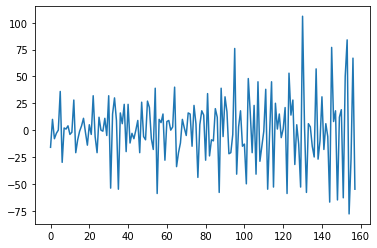

In [89]:
plt.plot(wave_1_data[state_ordered].iloc[:, 0].values)

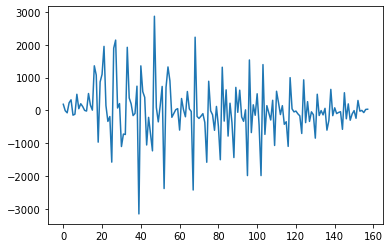

In [90]:
plt.plot(wave_1_data['AP'])